In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# 1. Setup the Environment

Transformers: For loading and fine-tuning the pre-trained RoBERTa model.

Datasets: For loading the MasakhaNER dataset.

Seqeval: For evaluating NER tasks (accuracy, precision, recall, F1-score).

In [ ]:
pip install transformers datasets seqeval

# Load the Dataset
Load the MasakhaNER dataset, which contains Swahili text annotated with named entities. Load the MasakhaNER dataset with trust_remote_code=True, This ensures that the dataset is loaded without requiring manual confirmation.

In [ ]:
from datasets import load_dataset

# Load the MasakhaNER dataset with trust_remote_code=True
dataset = load_dataset("masakhaner", "swa", trust_remote_code=True)

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 2109
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 300
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 604
    })
})


In [ ]:
# Print the first five elements separately
for i in range(10):
    print(dataset["train"][i])

{'id': '0', 'tokens': ['Wizara', 'ya', 'afya', 'ya', 'Tanzania', 'imeripoti', 'Jumatatu', 'kuwa', ',', 'watu', 'takriban', '14', 'zaidi', 'wamepata', 'maambukizi', 'ya', 'Covid', '-', '19', '.'], 'ner_tags': [3, 4, 4, 4, 4, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
{'id': '1', 'tokens': ['Walioambukizwa', 'wote', 'ni', 'raia', 'wa', 'Tanzania', ',', '13', 'wakiwa', 'Dar', '-', 'es', '-', 'salaam', 'na', 'mmoja', 'mjini', 'Arusha', '.'], 'ner_tags': [0, 0, 0, 0, 0, 5, 0, 0, 0, 5, 6, 6, 6, 6, 0, 0, 0, 5, 0]}
{'id': '2', 'tokens': ['Wizara', 'ya', 'afya', 'imeripoti', 'kwamba', 'juhudi', 'za', 'kufuatilia', 'watu', 'waliokuwa', 'karibu', 'na', 'wagonjwa', 'zinaendelea', '.'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
{'id': '3', 'tokens': ['Wakati', 'wa', 'maadimisho', 'ya', 'pasaka', ',', 'wakristo', 'walikusanyika', 'kanisani', 'kwa', 'maombi', 'bila', 'kuzingatia', 'ushauri', 'wa', 'wataalam', 'wa', 'afya', '.'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

# Preprocess the Data
Convert the dataset into a format suitable for the RoBERTa model. This involves tokenizing the text and aligning the labels with the tokenized input.
Explanation of add_prefix_space=True
Why is it needed? RoBERTa tokenizers treat spaces as part of the tokenization process. When working with pretokenized inputs (e.g., a list of words), the tokenizer needs to know that each word is prefixed with a space (except the first word). Setting add_prefix_space=True ensures that the tokenizer correctly handles this.

When to use it? Always use add_prefix_space=True when your input is already split into words or tokens (e.g., examples MasakhaNER dataset).

In [36]:
def tokenize_and_align_labels(examples):
    # Tokenize the input tokens
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        padding="max_length",
        max_length=128,
        is_split_into_words=True
    )

    # Align labels with tokenized input
    labels = []
    word_ids_list = []  # Store word_ids for each example

    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective words
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Special token (e.g., [CLS], [SEP])
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])  # New word
            else:
                label_ids.append(-100)  # Subword of the same word
            previous_word_idx = word_idx

        labels.append(label_ids)
        word_ids_list.append(word_ids)  # Save word_ids for later use

    # Add the original "tokens" field and "word_ids" field to the tokenized dataset
    tokenized_inputs["original_tokens"] = examples["tokens"]
    tokenized_inputs["labels"] = labels
    tokenized_inputs["word_ids"] = word_ids_list  # Add word_ids field

    return tokenized_inputs

In [37]:
# Apply tokenization to the dataset
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

# Check the result after tokenization
print(tokenized_datasets["test"].features)

Map:   0%|          | 0/2109 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/604 [00:00<?, ? examples/s]

{'id': Value(dtype='string', id=None), 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-DATE', 'I-DATE'], id=None), length=-1, id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'original_tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'word_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}


# Dataset Statistics
This visualization shows the number of examples in the train, validation, and test sets.

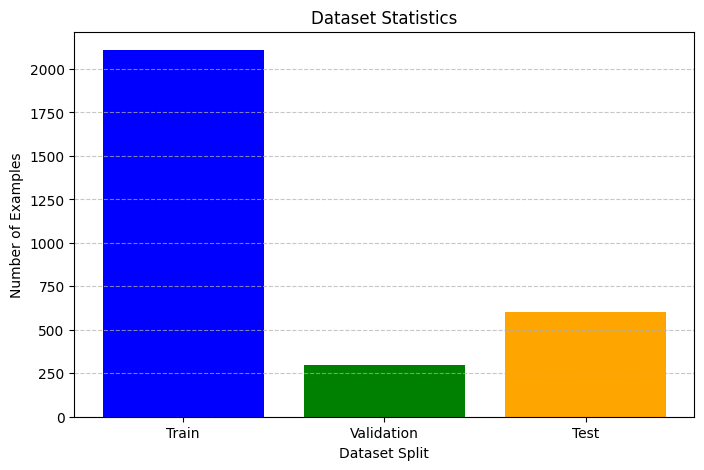

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dataset statistics
dataset_sizes = {
    'Train': 2109,
    'Validation': 300,
    'Test': 604
}

# Bar chart
categories = list(dataset_sizes.keys())
values = list(dataset_sizes.values())

plt.figure(figsize=(8, 5))
plt.bar(categories, values, color=['blue', 'green', 'orange'])
plt.title('Dataset Statistics')
plt.ylabel('Number of Examples')
plt.xlabel('Dataset Split')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Prepare the Dataset for PyTorch
Make sure your dataset is properly formatted for the Trainer:

In [ ]:
tokenized_datasets.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)

Load the model

In [ ]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.1 MB/s eta 0:00:00


In [ ]:
import evaluate
# Define the model
model = AutoModelForTokenClassification.from_pretrained(
    "benjamin/roberta-base-wechsel-swahili",
    num_labels=len(tokenized_datasets["train"].features["ner_tags"].feature.names)
)

# Define the metric
metric = evaluate.load("seqeval")  # Using evaluate to load the seqeval metric

# Ensure that the model has a mapping for the labels
label_list = tokenized_datasets["train"].features["ner_tags"].feature.names
id2label = {i: label for i, label in enumerate(label_list)}
label2id = {v: k for k, v in id2label.items()}

# Define data collator to handle padding
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at benjamin/roberta-base-wechsel-swahili and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Evaluation Metrics

In [ ]:
pip install seqeval

In [ ]:
import numpy as np
import evaluate


# Define the metric
metric = evaluate.load("seqeval")  # Using evaluate to load the seqeval metric

# Ensure that the model has a mapping for the labels
label_list = tokenized_datasets["train"].features["ner_tags"].feature.names
id2label = {i: label for i, label in enumerate(label_list)}
label2id = {v: k for k, v in id2label.items()}

# Define data collator to handle padding
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Function to compute metrics
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=-1)  # Get the predicted label indices

    # Remove padding tokens (label=-100 for padding tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for l in label if l != -100]
        for label in labels
    ]

    return metric.compute(predictions=true_predictions, references=true_labels)

# Model and Training Arguments

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",               # Save directory
    evaluation_strategy="epoch",          # Evaluate after each epoch
    save_strategy="epoch",                # Save model after each epoch
    logging_dir="./logs",                 # Directory for logs
    logging_steps=100,                    # Log every 100 steps
    per_device_train_batch_size=16,       # Batch size for training (adjust as needed)
    per_device_eval_batch_size=32,        # Batch size for evaluation (adjust as needed)
    num_train_epochs=5,                   # Total number of epochs (adjust as needed)
    learning_rate=5e-5,                   # Learning rate (adjust as needed)
    weight_decay=0.01,                    # Weight decay for regularization
    load_best_model_at_end=True,          # Load the best model at the end
    metric_for_best_model="eval_overall_f1",  # Use eval_overall_f1 for selecting the best model
    warmup_steps=500,                     # Number of warmup steps
    logging_first_step=True,              # Log the first step
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Initialize the Trainer

In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,                           # the model to train
    args=training_args,                    # training arguments
    data_collator=data_collator,           # data collator
    train_dataset=tokenized_datasets["train"],  # training dataset
    eval_dataset=tokenized_datasets["validation"],  # evaluation dataset
    compute_metrics=compute_metrics,       # custom metrics (precision, recall, F1)
)

# Verify Dataset Dimensions :
After applying the above changes, verify that the dataset has consistent dimensions by inspecting the tokenized data.

In [ ]:
print(tokenized_datasets["train"].features)

{'id': Value(dtype='string', id=None), 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-DATE', 'I-DATE'], id=None), length=-1, id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}


# Fine-Tuning

In [25]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: zda24m007 (zda24m007-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Date,Loc,Org,Per,Overall Precision,Overall Recall,Overall F1,Overall Accuracy
1,1.237500,0.150670,"{'precision': 0.5274725274725275, 'recall': 0.6, 'f1': 0.5614035087719298, 'number': 80}","{'precision': 0.6384615384615384, 'recall': 0.8217821782178217, 'f1': 0.7186147186147186, 'number': 303}","{'precision': 0.4090909090909091, 'recall': 0.20930232558139536, 'f1': 0.27692307692307694, 'number': 86}","{'precision': 0.6269230769230769, 'recall': 0.7951219512195122, 'f1': 0.7010752688172044, 'number': 205}",0.608917,0.709199,0.655243,0.950296
2,0.177100,0.078080,"{'precision': 0.782608695652174, 'recall': 0.9, 'f1': 0.8372093023255814, 'number': 80}","{'precision': 0.9142857142857143, 'recall': 0.9504950495049505, 'f1': 0.9320388349514563, 'number': 303}","{'precision': 0.6744186046511628, 'recall': 0.6744186046511628, 'f1': 0.6744186046511628, 'number': 86}","{'precision': 0.9289099526066351, 'recall': 0.9560975609756097, 'f1': 0.9423076923076924, 'number': 205}",0.872159,0.910979,0.891147,0.978246


Trainer is attempting to log a value of "{'precision': 0.5274725274725275, 'recall': 0.6, 'f1': 0.5614035087719298, 'number': 80}" of type <class 'dict'> for key "eval/DATE" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.6384615384615384, 'recall': 0.8217821782178217, 'f1': 0.7186147186147186, 'number': 303}" of type <class 'dict'> for key "eval/LOC" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.4090909090909091, 'recall': 0.20930232558139536, 'f1': 0.27692307692307694, 'number': 86}" of type <class 'dict'> for key "eval/ORG" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.6269230769230769, 'recall': 0.7951219512195122, 'f1': 0.7010752

Epoch,Training Loss,Validation Loss,Date,Loc,Org,Per,Overall Precision,Overall Recall,Overall F1,Overall Accuracy
1,1.237500,0.150670,"{'precision': 0.5274725274725275, 'recall': 0.6, 'f1': 0.5614035087719298, 'number': 80}","{'precision': 0.6384615384615384, 'recall': 0.8217821782178217, 'f1': 0.7186147186147186, 'number': 303}","{'precision': 0.4090909090909091, 'recall': 0.20930232558139536, 'f1': 0.27692307692307694, 'number': 86}","{'precision': 0.6269230769230769, 'recall': 0.7951219512195122, 'f1': 0.7010752688172044, 'number': 205}",0.608917,0.709199,0.655243,0.950296
2,0.177100,0.078080,"{'precision': 0.782608695652174, 'recall': 0.9, 'f1': 0.8372093023255814, 'number': 80}","{'precision': 0.9142857142857143, 'recall': 0.9504950495049505, 'f1': 0.9320388349514563, 'number': 303}","{'precision': 0.6744186046511628, 'recall': 0.6744186046511628, 'f1': 0.6744186046511628, 'number': 86}","{'precision': 0.9289099526066351, 'recall': 0.9560975609756097, 'f1': 0.9423076923076924, 'number': 205}",0.872159,0.910979,0.891147,0.978246
3,0.081400,0.087413,"{'precision': 0.7802197802197802, 'recall': 0.8875, 'f1': 0.8304093567251462, 'number': 80}","{'precision': 0.9144736842105263, 'recall': 0.9174917491749175, 'f1': 0.9159802306425042, 'number': 303}","{'precision': 0.603448275862069, 'recall': 0.813953488372093, 'f1': 0.693069306930693, 'number': 86}","{'precision': 0.9521531100478469, 'recall': 0.9707317073170731, 'f1': 0.961352657004831, 'number': 205}",0.858333,0.916914,0.886657,0.974391
4,0.042700,0.099281,"{'precision': 0.7717391304347826, 'recall': 0.8875, 'f1': 0.8255813953488372, 'number': 80}","{'precision': 0.8888888888888888, 'recall': 0.9504950495049505, 'f1': 0.9186602870813396, 'number': 303}","{'precision': 0.6095238095238096, 'recall': 0.7441860465116279, 'f1': 0.6701570680628273, 'number': 86}","{'precision': 0.9333333333333333, 'recall': 0.9560975609756097, 'f1': 0.944578313253012, 'number': 205}",0.846785,0.918398,0.881139,0.968470
5,0.035600,0.104519,"{'precision': 0.6792452830188679, 'recall': 0.9, 'f1': 0.7741935483870968, 'number': 80}","{'precision': 0.9073482428115016, 'recall': 0.9372937293729373, 'f1': 0.922077922077922, 'number': 303}","{'precision': 0.66, 'recall': 0.7674418604651163, 'f1': 0.7096774193548386, 'number': 86}","{'precision': 0.9383886255924171, 'recall': 0.9658536585365853, 'f1': 0.9519230769230769, 'number': 205}",0.849315,0.919881,0.883191,0.971224


Trainer is attempting to log a value of "{'precision': 0.7802197802197802, 'recall': 0.8875, 'f1': 0.8304093567251462, 'number': 80}" of type <class 'dict'> for key "eval/DATE" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9144736842105263, 'recall': 0.9174917491749175, 'f1': 0.9159802306425042, 'number': 303}" of type <class 'dict'> for key "eval/LOC" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.603448275862069, 'recall': 0.813953488372093, 'f1': 0.693069306930693, 'number': 86}" of type <class 'dict'> for key "eval/ORG" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9521531100478469, 'recall': 0.9707317073170731, 'f1': 0.961352657

TrainOutput(global_step=660, training_loss=0.2521613834482251, metrics={'train_runtime': 13952.3925, 'train_samples_per_second': 0.756, 'train_steps_per_second': 0.047, 'total_flos': 688887169493760.0, 'train_loss': 0.2521613834482251, 'epoch': 5.0})

In [26]:
# Evaluate the model
results = trainer.evaluate(tokenized_datasets["test"])
print(results)

Trainer is attempting to log a value of "{'precision': 0.7538461538461538, 'recall': 0.9074074074074074, 'f1': 0.8235294117647058, 'number': 162}" of type <class 'dict'> for key "eval/DATE" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.8864541832669323, 'recall': 0.9611231101511879, 'f1': 0.9222797927461138, 'number': 463}" of type <class 'dict'> for key "eval/LOC" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.7101449275362319, 'recall': 0.665158371040724, 'f1': 0.6869158878504674, 'number': 221}" of type <class 'dict'> for key "eval/ORG" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9429429429429429, 'recall': 0.9429429429429429, '

{'eval_loss': 0.07884173840284348, 'eval_DATE': {'precision': 0.7538461538461538, 'recall': 0.9074074074074074, 'f1': 0.8235294117647058, 'number': 162}, 'eval_LOC': {'precision': 0.8864541832669323, 'recall': 0.9611231101511879, 'f1': 0.9222797927461138, 'number': 463}, 'eval_ORG': {'precision': 0.7101449275362319, 'recall': 0.665158371040724, 'f1': 0.6869158878504674, 'number': 221}, 'eval_PER': {'precision': 0.9429429429429429, 'recall': 0.9429429429429429, 'f1': 0.9429429429429429, 'number': 333}, 'eval_overall_precision': 0.85125303152789, 'eval_overall_recall': 0.8931297709923665, 'eval_overall_f1': 0.8716887417218543, 'eval_overall_accuracy': 0.9759880589266013, 'eval_runtime': 258.8837, 'eval_samples_per_second': 2.333, 'eval_steps_per_second': 0.073, 'epoch': 5.0}


# Training Performance Over Epochs
This visualization plots the training loss, validation loss, precision, recall, F1-score, and accuracy over epochs.

Prepare the Data
Organize the data into separate lists for each metric (precision, recall, F1-score, accuracy) for each epoch.

In [54]:
# Extracted data from the training process
epochs = [1, 2, 3, 4, 5]

# Training Loss
training_loss = [1.237500, 0.177100, 0.081400, 0.042700, 0.035600]

# Validation Loss
validation_loss = [0.150670, 0.078080, 0.087413, 0.099281, 0.104519]

# DATE Metrics
date_precision = [0.527473, 0.782609, 0.780220, 0.771739, 0.679245]
date_recall = [0.6, 0.9, 0.8875, 0.8875, 0.9]
date_f1 = [0.561404, 0.837209, 0.830409, 0.825581, 0.774194]

# LOC Metrics
loc_precision = [0.638462, 0.914286, 0.914474, 0.888889, 0.907348]
loc_recall = [0.821782, 0.950495, 0.917492, 0.950495, 0.937294]
loc_f1 = [0.718615, 0.932039, 0.915980, 0.918660, 0.922078]

# ORG Metrics
org_precision = [0.409091, 0.674419, 0.603448, 0.609524, 0.66]
org_recall = [0.209302, 0.674419, 0.813953, 0.744186, 0.767442]
org_f1 = [0.276923, 0.674419, 0.693069, 0.670157, 0.709677]

# PER Metrics
per_precision = [0.626923, 0.928910, 0.952153, 0.933333, 0.938389]
per_recall = [0.795122, 0.956098, 0.970732, 0.956098, 0.965854]
per_f1 = [0.701075, 0.942308, 0.961353, 0.944578, 0.951923]

# Overall Metrics
overall_precision = [0.608917, 0.872159, 0.858333, 0.846785, 0.849315]
overall_recall = [0.709199, 0.910979, 0.916914, 0.918398, 0.919881]
overall_f1 = [0.655243, 0.891147, 0.886657, 0.881139, 0.883191]
overall_accuracy = [0.950296, 0.978246, 0.974391, 0.968470, 0.971224]

Create the Visualization

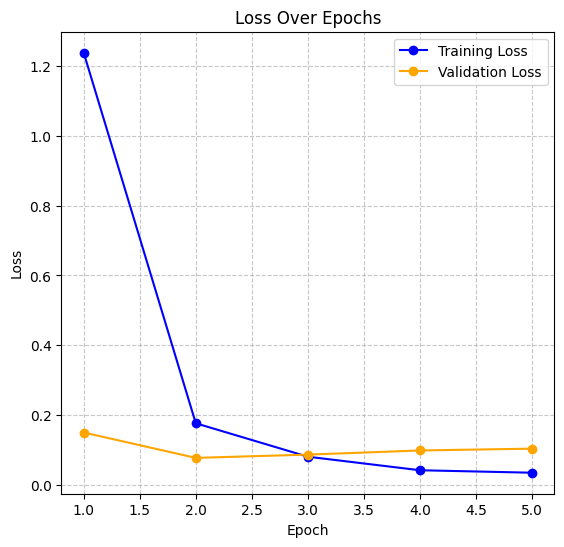

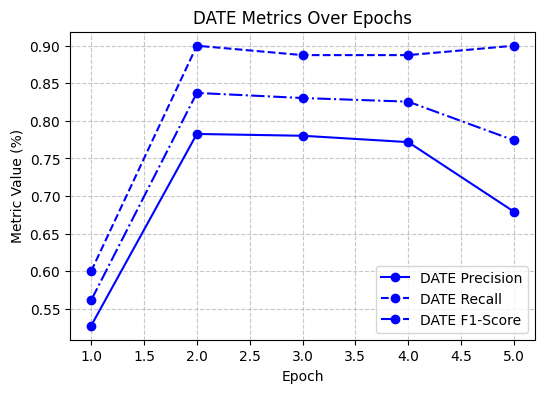

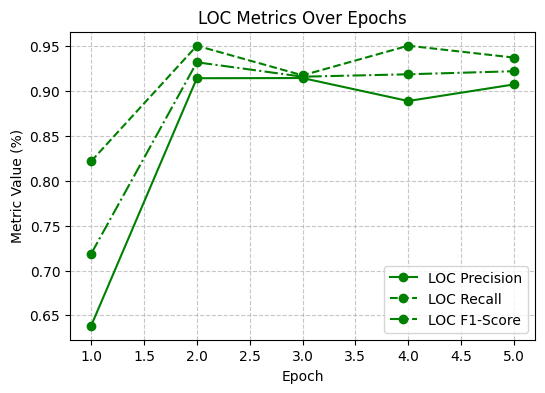

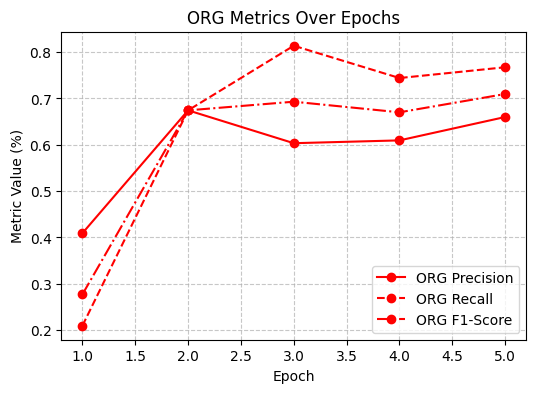

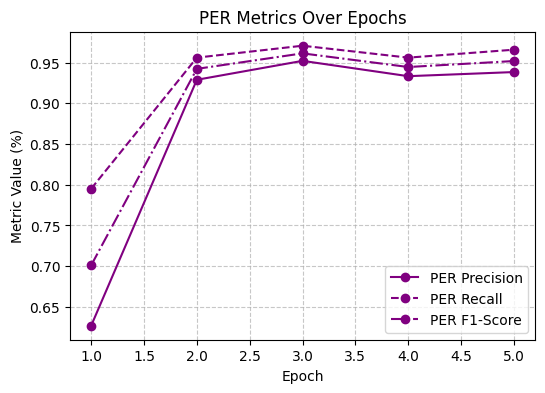

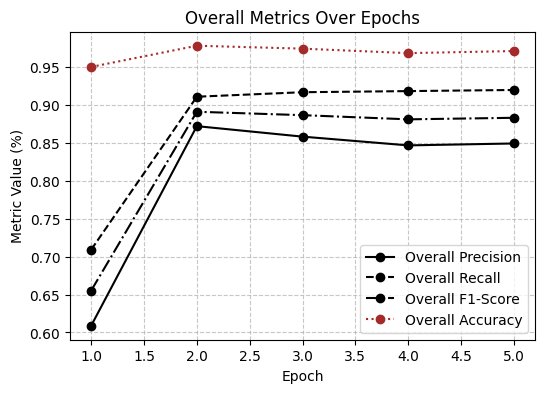

In [56]:
# Line plot for visualization
plt.figure(figsize=(14, 6))

# Subplot 1: Losses
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss', marker='o', color='blue')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(linestyle='--', alpha=0.7)

# Function to plot metrics for a specific entity type
def plot_entity_metrics(entity_name, precision, recall, f1, color):
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, precision, label=f'{entity_name} Precision', marker='o', linestyle='-', color=color)
    plt.plot(epochs, recall, label=f'{entity_name} Recall', marker='o', linestyle='--', color=color)
    plt.plot(epochs, f1, label=f'{entity_name} F1-Score', marker='o', linestyle='-.', color=color)
    plt.title(f'{entity_name} Metrics Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value (%)')
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7)
    plt.show()

# Plot DATE metrics
plot_entity_metrics("DATE", date_precision, date_recall, date_f1, 'blue')

# Plot LOC metrics
plot_entity_metrics("LOC", loc_precision, loc_recall, loc_f1, 'green')

# Plot ORG metrics
plot_entity_metrics("ORG", org_precision, org_recall, org_f1, 'red')

# Plot PER metrics
plot_entity_metrics("PER", per_precision, per_recall, per_f1, 'purple')

# Plot Overall metrics
plt.figure(figsize=(6, 4))
plt.plot(epochs, overall_precision, label='Overall Precision', marker='o', linestyle='-', color='black')
plt.plot(epochs, overall_recall, label='Overall Recall', marker='o', linestyle='--', color='black')
plt.plot(epochs, overall_f1, label='Overall F1-Score', marker='o', linestyle='-.', color='black')
plt.plot(epochs, overall_accuracy, label='Overall Accuracy', marker='o', linestyle=':', color='brown')
plt.title('Overall Metrics Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Metric Value (%)')
plt.legend()
plt.grid(linestyle='--', alpha=0.7)
plt.show()

# Save the Best Model
After training, save your fine-tuned model:

In [28]:
model.save_pretrained("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_model")

('./fine_tuned_model/tokenizer_config.json',
 './fine_tuned_model/special_tokens_map.json',
 './fine_tuned_model/vocab.json',
 './fine_tuned_model/merges.txt',
 './fine_tuned_model/added_tokens.json',
 './fine_tuned_model/tokenizer.json')

# Validate with Swahili Speakers
After evaluating the model, validate the identified named entities with Swahili-speaking members for linguistic accuracy.

Sample 500 Named Entities: Extract 500 named entities from the test set predictions.

Create a Validation Set: Share these entities with Swahili speakers for validation.

Calculate Linguistic Accuracy: Compare the model's predictions with human-validated labels.

In [29]:
print(tokenized_datasets["test"].features)

{'id': Value(dtype='string', id=None), 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-DATE', 'I-DATE'], id=None), length=-1, id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}


# Extract 500 Named Entities
From the test set predictions, extract 500 named entities. These entities should represent a diverse sample of the categories (e.g., PERSON, LOCATION, ORGANIZATION, etc.) to ensure comprehensive validation.

In [38]:
def extract_named_entities(predictions, tokenized_test_set):
    entities = []
    label_list = tokenized_test_set.features["ner_tags"].feature.names

    for pred, example in zip(predictions, tokenized_test_set):
        tokens = example["original_tokens"]  # Use "original_tokens" instead of "tokens"
        word_ids = example["word_ids"]  # Access the "word_ids" field
        current_entity = []
        entity_type = None

        for idx, (p, word_id) in enumerate(zip(pred, word_ids)):
            if word_id is None:  # Skip special tokens
                continue

            label = label_list[p]

            if label != "O":  # If it's a named entity
                if not current_entity:  # Start of a new entity
                    entity_type = label.split("-")[-1]
                    current_entity.append(tokens[word_id])
                else:
                    current_entity.append(tokens[word_id])
            else:
                if current_entity:  # End of an entity
                    entities.append(("".join(current_entity), entity_type))
                    current_entity = []

        if current_entity:  # Add the last entity if it exists
            entities.append(("".join(current_entity), entity_type))

    return entities[:500]  # Return the first 500 entities

# Generate Predictions
Use the Trainer object to generate predictions on the test set.

# Call the Function
Call the function to extract 500 named entities.

In [39]:
# Generate predictions on the test set
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

# Extract 500 named entities
sample_entities = extract_named_entities(predictions, tokenized_datasets["test"])

# Print the first few entities for verification
for entity, entity_type in sample_entities[:10]:
    print(f"Entity: {entity}, Type: {entity_type}")

Entity: YoweriMuseveni, Type: PER
Entity: jumanne, Type: DATE
Entity: Museveni, Type: PER
Entity: Museveni, Type: PER
Entity: 9, Type: DATE
Entity: siku21, Type: DATE
Entity: Museveni, Type: PER
Entity: Museveni, Type: PER
Entity: Uganda, Type: LOC
Entity: RuhakanaRuhakanaRuhakanaRugundaRugunda, Type: PER


# Prepare the Validation Set
Organize the extracted named entities into a format that can be easily shared with Swahili speakers. This could be a CSV file or a simple text document.

In [46]:
import csv

# Define the output file path
output_file = "/content/drive/MyDrive/NLP project/validation_set.csv"

# Open the file in write mode with UTF-8 encoding
with open(output_file, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)

    # Write the header row
    writer.writerow(["Entity", "Type", "Human Label", "Correct?"])

    # Write each entity and its type to the CSV file
    for entity, entity_type in sample_entities:
        writer.writerow([entity, entity_type, "", ""])  # Leave Human Label and Correct? blank initially

print(f"Entities saved to {output_file}")

Entities saved to /content/drive/MyDrive/NLP project/validation_set.csv


Verify the CSV File

In [47]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv("/content/drive/MyDrive/NLP project/validation_set.csv")

# Display the first few rows
print(df.head())

           Entity  Type  Human Label  Correct?
0  YoweriMuseveni   PER          NaN       NaN
1         jumanne  DATE          NaN       NaN
2        Museveni   PER          NaN       NaN
3        Museveni   PER          NaN       NaN
4               9  DATE          NaN       NaN


In [42]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Share with Swahili Speakers
Distribute the CSV file or text document to Swahili-speaking validators. Provide clear instructions on how to review the named entities:

Review the Entity : Check if the entity is correctly identified.
Assign a Human Label : If the entity is incorrect, provide the correct label.
Mark Correctness : Indicate whether the model's prediction is correct (Yes) or incorrect (No).
Example Instructions:
If the entity "Dodoma" is correctly labeled as LOCATION, mark Correct? as Yes.
If the entity "Apple" is incorrectly labeled as PERSON, mark Correct? as No and update the Human Label to ORGANIZATION.

# Collect Feedback
Once the validators complete their reviews, collect the updated CSV file or document. This feedback will include corrections and confirmations of the model's predictions.

# Calculate Linguistic Accuracy
Analyze the feedback to calculate the linguistic accuracy of the model's predictions.

Metrics to Compute:
Accuracy : Percentage of entities correctly identified by the model.
Error Rate : Percentage of entities incorrectly identified.
Confusion Matrix : Breakdown of errors by entity type (e.g., PERSON vs. LOCATION).

In [52]:
import pandas as pd

# Load the validated CSV file
validated_data = pd.read_csv("/content/drive/MyDrive/NLP project/validation_human_label.csv")

# Filter rows where correctness is marked
correct_rows = validated_data[validated_data["Correct?"] == "Yes"]
incorrect_rows = validated_data[validated_data["Correct?"] == "No"]

# Calculate accuracy
total_entities = len(validated_data)
correct_entities = len(correct_rows)
accuracy = correct_entities / total_entities * 100

print(f"Linguistic Accuracy: {accuracy:.2f}%")

Linguistic Accuracy: 96.20%


<Figure size 800x600 with 0 Axes>

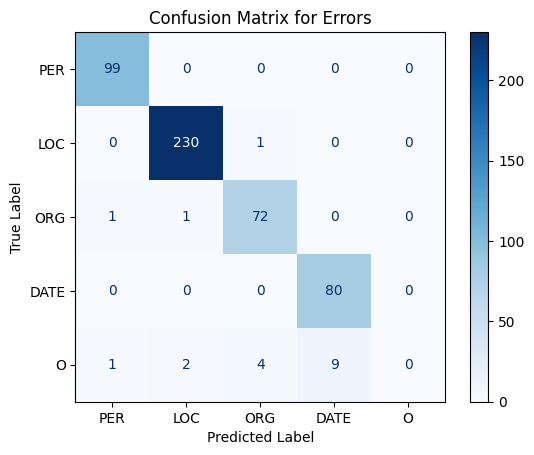

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define the unique entity types
labels = ["PER", "LOC", "ORG", "DATE", "O"]

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=labels)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title('Confusion Matrix for Errors')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Analyze Errors
Identify common errors in the model's predictions and use this information to improve the model further. For example:

Are certain entity types more prone to errors?
Are there specific linguistic patterns that the model struggles with?

In [59]:
# Group errors by entity type
error_analysis = incorrect_rows.groupby("Type").size().reset_index(name="Count")
error_analysis["Percentage"] = error_analysis["Count"] / len(incorrect_rows) * 100

print("Error Analysis by Entity Type:")
print(error_analysis)

Error Analysis by Entity Type:
   Type  Count  Percentage
0  DATE      9   47.368421
1   LOC      3   15.789474
2   ORG      5   26.315789
3   PER      2   10.526316
